# Classification

!!! questions "Questions"  
    - What metrics are used to for evaluation in a classification problem?
    - What dataset will we be working with today?
    - What exploratory data analysis do we need to carry out on 
      datasets we plan to work with for classification?
    - How do we split our data into training and testing sets?
    - How can we use scikit-learn to classify data in python?
    - How can we find out which hyperparameters are best for classification?
    
!!! objectives "Objectives"  
    - Explain what a confusion matrix is, and how it relates to common 
      classification error metrics
    - Understand how missing data can be hidden within normal-looking datasets
    - Use the scikit-learn library to work with data
    - Learn how to build and evaluate classifiers
    - Use the online documentation to figure out what the hyperparameters 
      are for a specific method
    - Build classification models using KNN, naive bayes, regularised 
      and boosted logistic regression, decision trees and a random forest

## What is a classifier?

A classifier is some kind of rule / black box / widget that you can feed a new observation/data/record and it will decide whether or not it is part of a given class. E.g. below, we are classifying the animals to be either *cat* or *not cat*.

![A classifier for cats and not cats](../fig/50-CatNotCat.jpg)

You can have classifiers for anything you can have a yes/no answer to, e.g.

- Is this a cat? 🐱
- Do these test results indicate cancer? 🚑
- Is this email spam or not spam? 📧

You can also have classifiers that categorise things into multiple (more than two) categories e.g.

- Which animal is this, out of the 12 animals I have trained my model on? 🐱
- Do these test results indicate {none, stage 1, stage 2, stage 3, stage 4} cancer? 🚑
- Is this email important, not important but not spam, or spam? 📧

It is clear that in some of these examples we are more concerned with being wrong in one direction than the other, e.g. it's better to let some spam email through accidentally than to block all of it but also junk important emails from people you know. Likewise, we would prefer our medical tests to err on the side of caution and not give a negative test result to someone who needs treatment. So we will need to adjust a parameter to decide how much we want to trade this off.

## Model evaluation (classification)

For now, let's imagine we have a classifier already. How can we test it to see how good it is?
A good start is a confusion matrix - a table of what test data it labels correctly and incorrectly.

![An demonstration of a confusion matrix for a cat classifier that has labelled 100 animals as cats or not-cats.](../fig/50-CatConfusion.jpg)

### Confusion Matrix

When applying classification models, we often use a confusion matrix to evaluate certain performance measures. A confusion matrix is simply a matrix that compares "the truth" to the labels generated by your classifier. When we label a cat correctly, we refer to this as a true positive. When we fail to label a cat as a cat, this is called a false negative.  However, if we label something which is not a cat as a cat, this is called a false positive; and of course if we correctly label something which is not a cat, as not a cat, then this is a true negative.

### Some common metrics

![Error metrics](../fig/50-ErrorMetrics.png)

#### AUC: Area under the curve

A good classifier will have high precision and high specificity, minimizing both false positives and false negatives. In practice, and with an imperfect classifier, you can tune a knob to say which of those two you care more about. There will be some kind of a trade-off between the two.

To capture this balance, we often use a Receiver Operator Characteristic (ROC) curve that plots the false positive rate along the x-axis and the true positive rate along the y-axis, for all possible trade-offs. A line that is diagonal from the lower left corner to the upper right corner represents a random guess at labelling each example. The higher the line is in the upper left-hand corner, the better the classifier in general. AUC computes the area under this curve. For a perfect classifier, AUC = 1, for a random guess, AUC=0.5. Objective: maximize.

![A Receiver Operator Characteristic (ROC) curve, from which the Area Under the Curve (AUC) can be calculated.](../fig/50-CatArea.jpg)


## Pima Indians Diabetes
Today, we are going to be working with the [Pima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). This is a classic dataset from the UCI machine learning repository, which is now hosted on kaggle. We have downloaded the .csv file of this dataset from kaggle. It contains the following variables:



1. Pregnancies --- Number of times pregnant
2. Glucose --- Plasma glucose concentration at 2 hours in an [oral glucose tolerance test](https://en.wikipedia.org/wiki/Glucose_tolerance_test)
3. BloodPressure --- Diastolic blood pressure (mm Hg)
4. SkinThickness --- Triceps skin fold thickness (mm) - [a measure correlated with body fat](https://en.wikipedia.org/wiki/Anthropometry_of_the_upper_arm)
5. Insulin --- 2-Hour serum insulin (μU/ml)
6. BMI --- Body mass index (weight in kg/(height in m)$^2$)
7. DiabetesPedigreeFunction --- Diabetes pedigree function, explained below
8. Age --- Age (years)
9. Outcome --- diabetes status (1 - diabetic; 0 - non-diabetic)


The diabetes pedigree function was developed by [Smith 1988](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/) to provide a synthesis of the diabetes mellitus history in relatives and the genetic relationship of those relatives to the subject. It uses information from parents, grandparents, siblings, aunts and uncles, and first cousin to provide a measure of the expected genetic influence of affected and unaffected relatives on the subject’s eventual diabetes risk:

$$
DPF = \frac{ \sum_i K_i (88 - ADM_i) + 20}{ \sum_j K_j (ALC_j - 14) + 50}
$$


- $i$ --- ranges across all relatives who HAD developed diabetes by subject's examination date
- $j$ --- ranges across all relatives who HAD NOT developed diabetes by subject's examination date
- $K_x$ --- percentage of genes shared by relative and subject. Equal to:
      - 0.5 when relative is parent or full sibling
      - 0.25 when relative is half-sibling, grandparent, aunt or uncle
      - 0.125 when relative is half aunt, half uncle or first cousin
- $ADM_i$ --- age when diabetes was diagnosed
- $ALC_j$ --- age of relative when last "non-diabetic" assessment was made
- 88 and 14 --- constants --- maximum and minimum age at which patients in study were diagnosed with diabetes
- Constants 20 and 50 chosen so that:
      - A subject with no relatives has DPF slighly lower than average
      - DPF value decreases as young relatives free of diabetes join the database
      - DPF increases quickly as known relatives develop diabetes
  
DPF increases as:

- the number of relatives with diabetes increases
- the age at which those relatives develop diabetes decreases
- percentage of genes these relatives share with subject increase

DPF decreases as:

- the number of relatives who never develop diabetes increases
- their ages at last examination increase
- percentage of genes these relatives share with subject increase


## Let's Explore our data

In [1]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import statsmodels.api as sm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
sns.set(font_scale = 1.5)

### Load Data

In [2]:
diabetes = pd.read_csv('data/diabetes.csv') # read csv

Explore the variables:

In [3]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Summary info
Shape of data frame

In [5]:
diabetes.shape

(768, 9)

Look for missing data:

In [6]:
diabetes.count()

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

It seems like there is no missing data.
Get a summary of the data frame:

In [7]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


!!! challenge "Challenge"
    Look at the output of summary above and the table that 
    explains what each of the variables are. Do the values for all 
    
    - (a) Pregnancies and Glucose
    - (b) Blood pressure and Skin thickness
    - (c) Insulin and DiabetesPedigreeFunction, and
    - (d) BMI and Age  

    make sense?

    If not, how do you think we should deal with them? 
    Can you hypothesise what the consequences of this approach would be?

    ??? "Solution"
    
        ```python
        # possibly missing
        diabetes[diabetes == 0].count()

        # not missing
        diabetes[diabetes != 0].count()
        ```
        
        It is clear that the values of several variables are 
        zero when it is impossible for them to be so (i.e. this 
        value could not be zero if it was measured). Hence, we 
        are dealing with "hidden" missing data, and should recode it as NA.

        The following variables have zero "values" that are actually 
        likely to be missing:

        1. Glucose (a)
        2. BloodPressure (b)
        3. SkinThickness (b)
        4. Insulin (c)
        5. BMI (d)

### Let’s use visualisation to further explore the dataset:

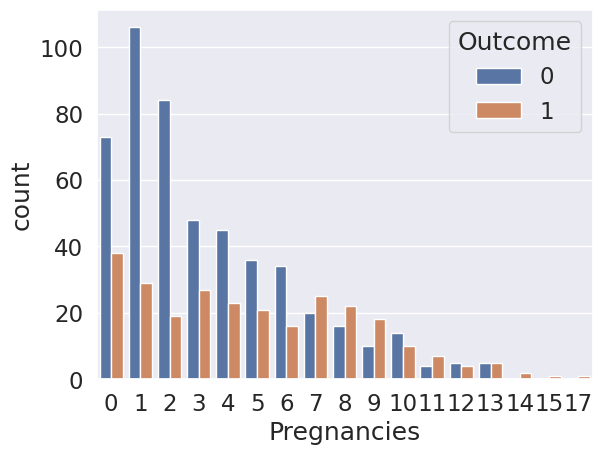

In [8]:
sns.countplot(
    x="Pregnancies",
    hue="Outcome", 
    data=diabetes
);

In [9]:
diabetes['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

If we wanted to look at all possible scatterplot pairs we would do something like:

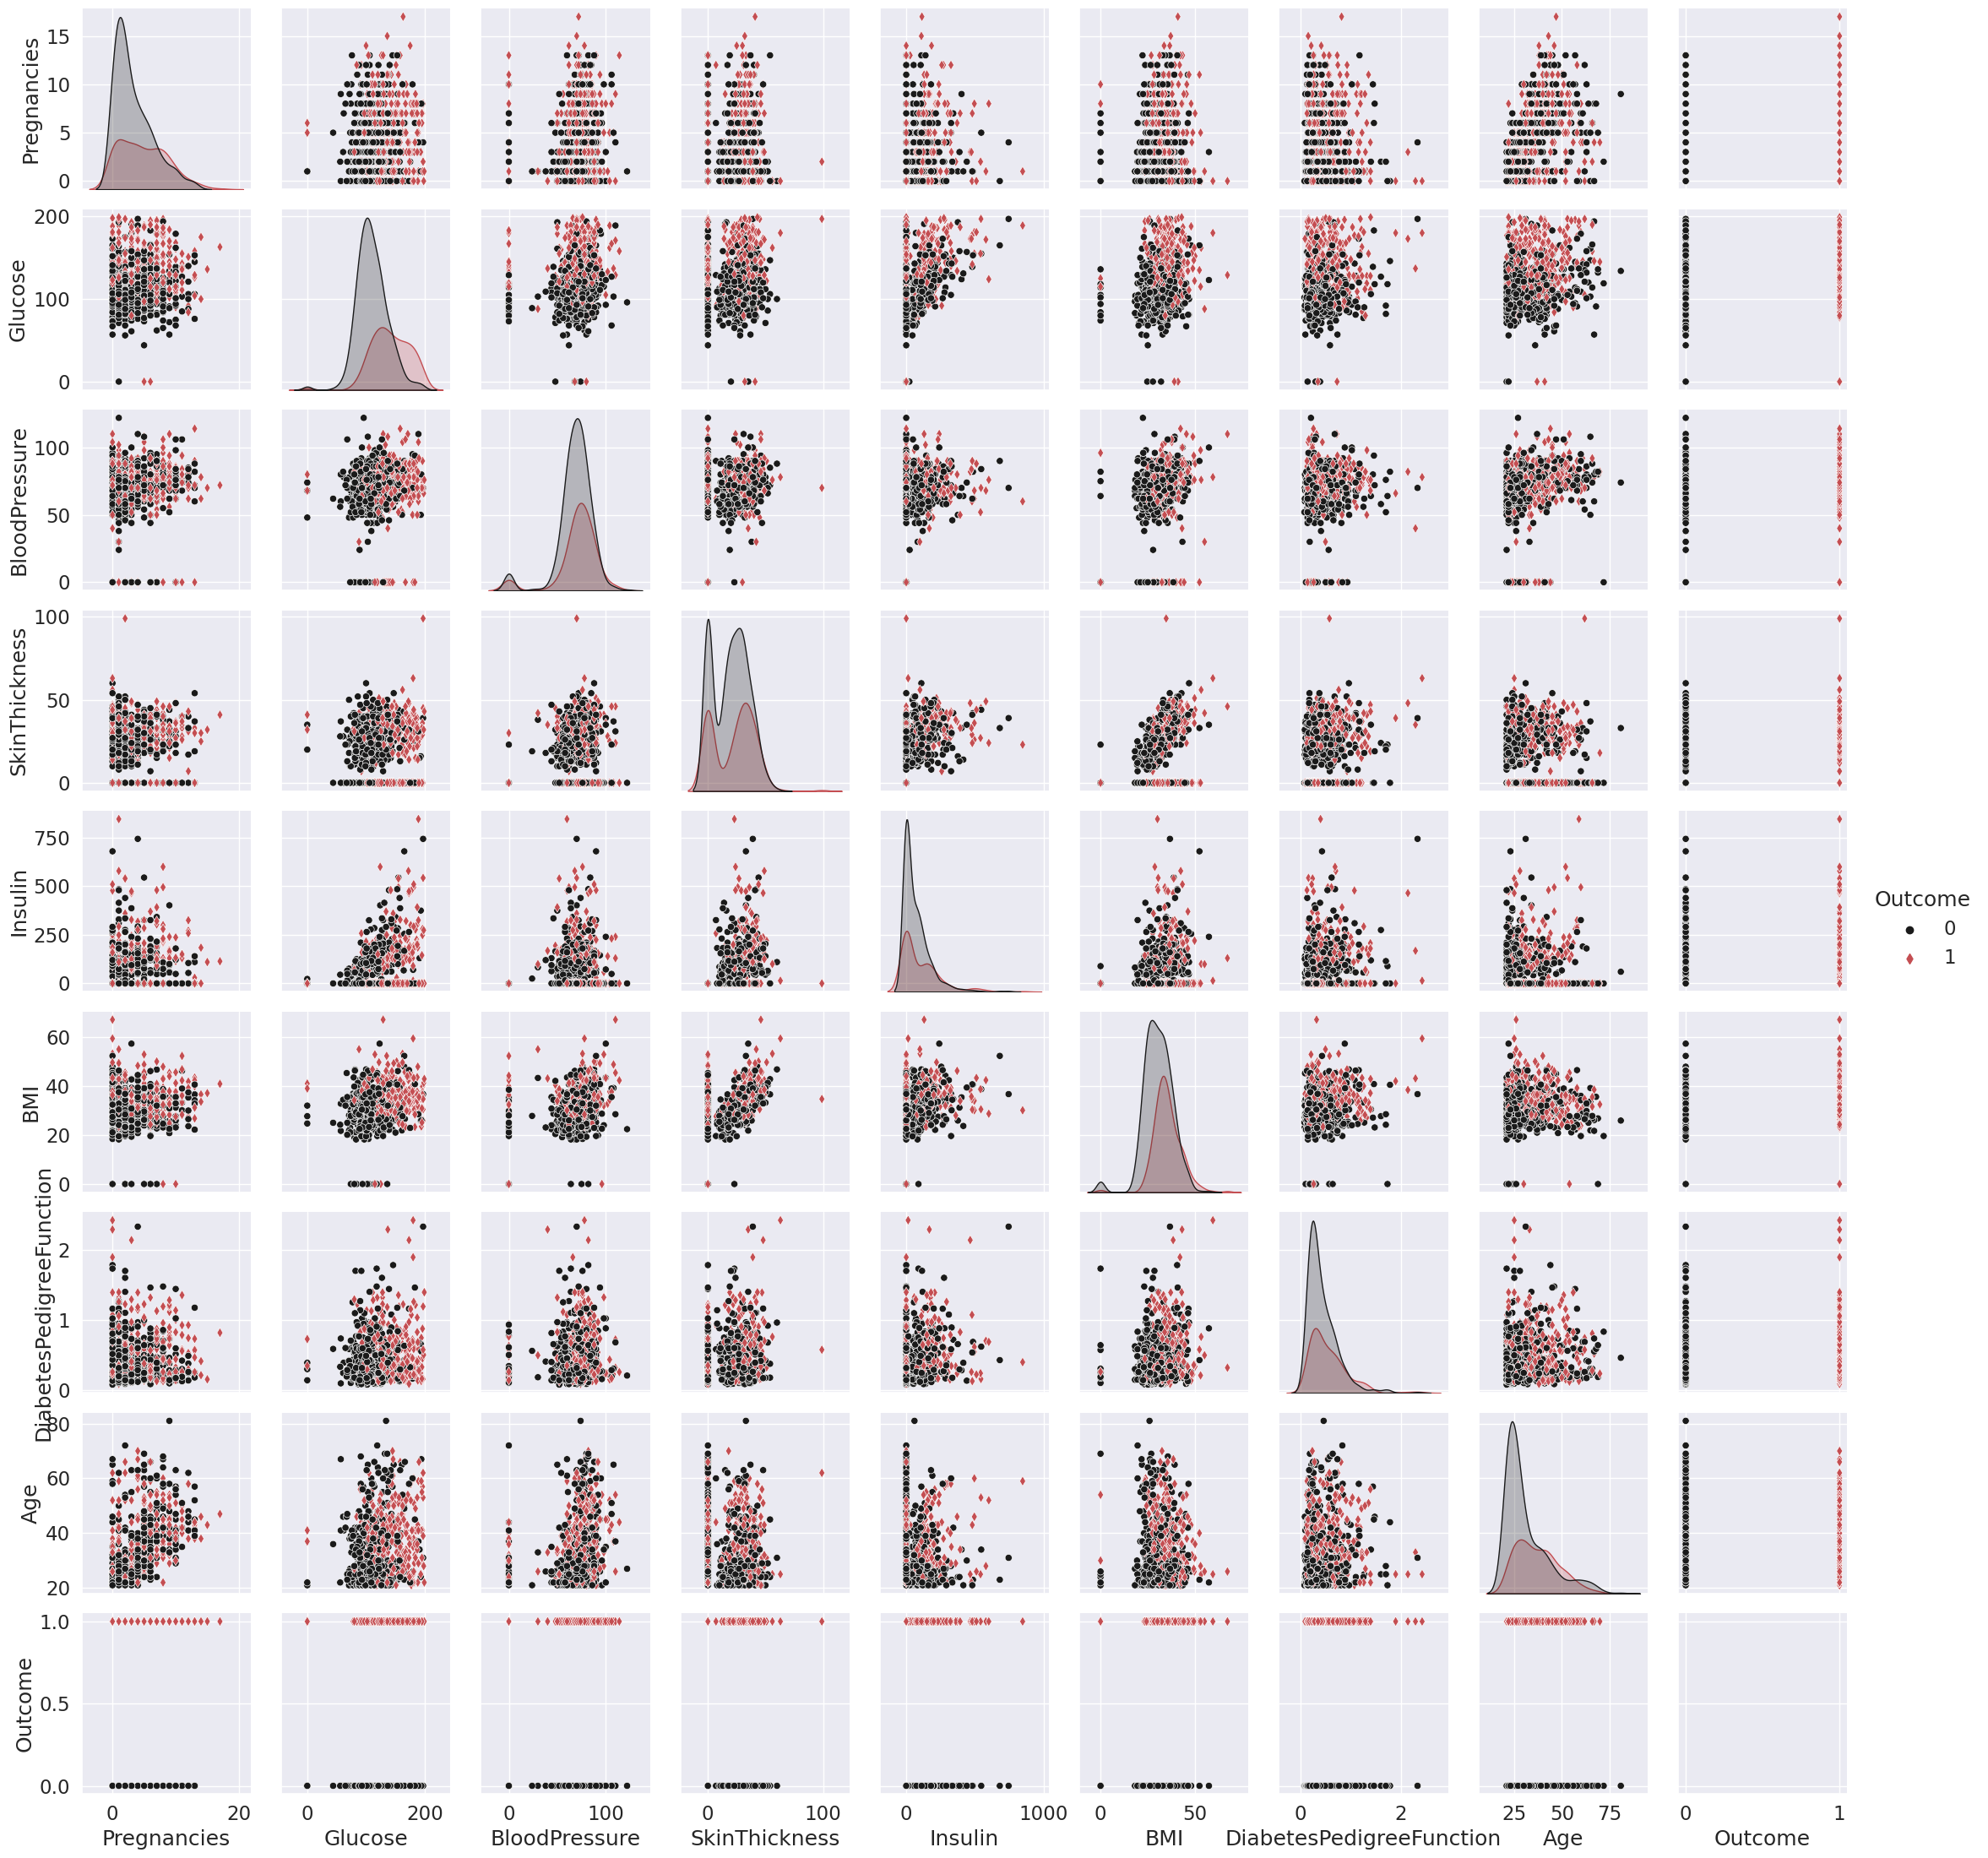

In [10]:
num_vars = diabetes.select_dtypes(exclude = ['object']).columns

sns.pairplot(
    data=diabetes,
    vars=num_vars,
    hue='Outcome',
    palette={0:'k',1:'r'},
    # use kernel density estimates for univariate plots
    diag_kind='kde',
    # make the shape of points circular and diamond, respectively
    markers=["o", "d"]
);

Generate a boxplot by possible prediction variables. Which do you hypothesize would be easiest for us to use to separate the data?

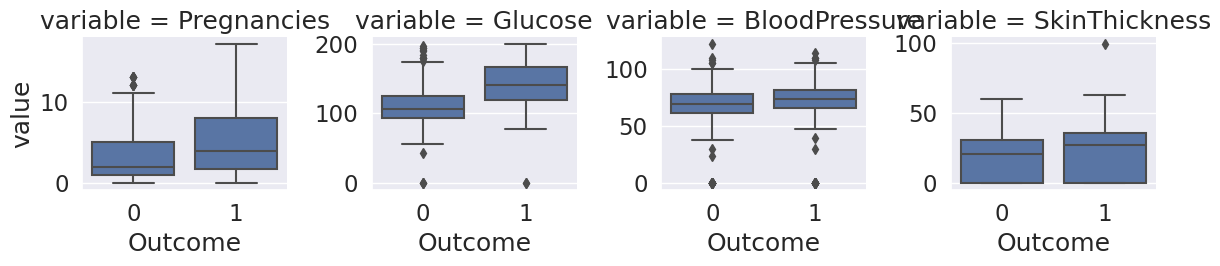

In [11]:
# copy the original dataframe
diabetes2 = diabetes.copy()
# create a new patient id column
diabetes2['PatientID'] = range(1, len(diabetes2) + 1)
# melt that dataframe
diabetes2 = diabetes2.melt(id_vars=['PatientID','Outcome'])

grid = sns.axisgrid.FacetGrid(
    diabetes2[diabetes2["variable"].isin(num_vars[:4])], 
    col='variable', 
    # y axis scale different for each boxplot
    sharey=False
)
grid.map(sns.boxplot, 'Outcome', 'value', order=[0, 1]);

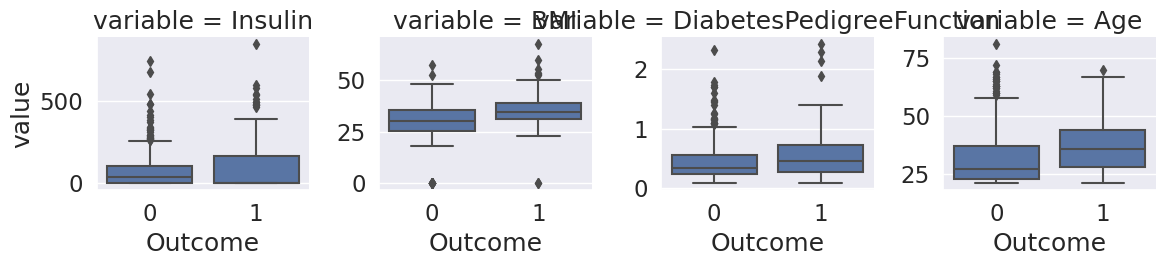

In [12]:
grid = sns.axisgrid.FacetGrid(
    diabetes2[diabetes2["variable"].isin(num_vars[4:])], 
    col='variable', 
    # y axis scale different for each boxplot
    sharey=False
)
grid.map(sns.boxplot, 'Outcome','value', order=[0, 1]);

Make a correlation plot betwee all numeric variables

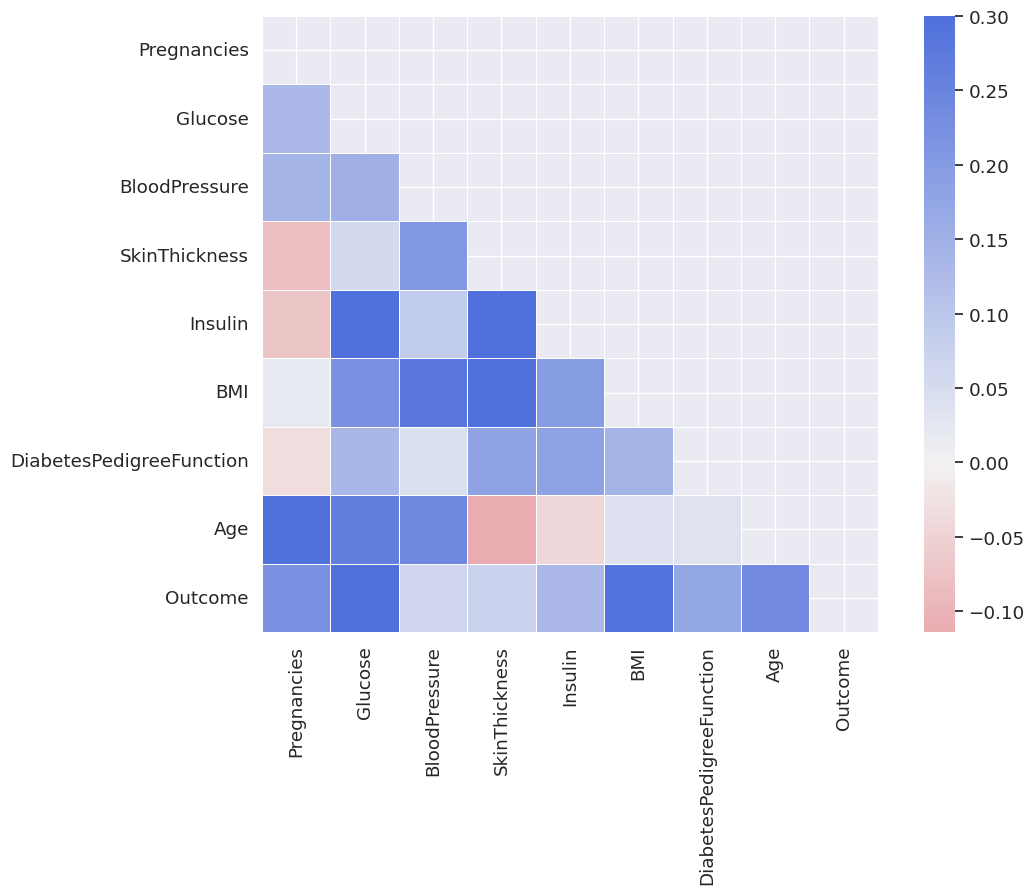

In [13]:
corr = diabetes.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# hue_negative, hue_positive
cmap = sns.diverging_palette(10, 260, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0., square=True, linewidths=.5);

## Prepare Data

Let’s replace the missing values in the diabetes data frame with NaN.

In [14]:
# get the column names
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [15]:
replaceVars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']

In [16]:
# mark zero values as missing or NaN
diabetes[replaceVars] = diabetes[replaceVars].replace(0, np.nan)

In [17]:
diabetes.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Let’s generate a newcorrelation plot where the missing data has been properly recoded as NaN. Which correlations change?

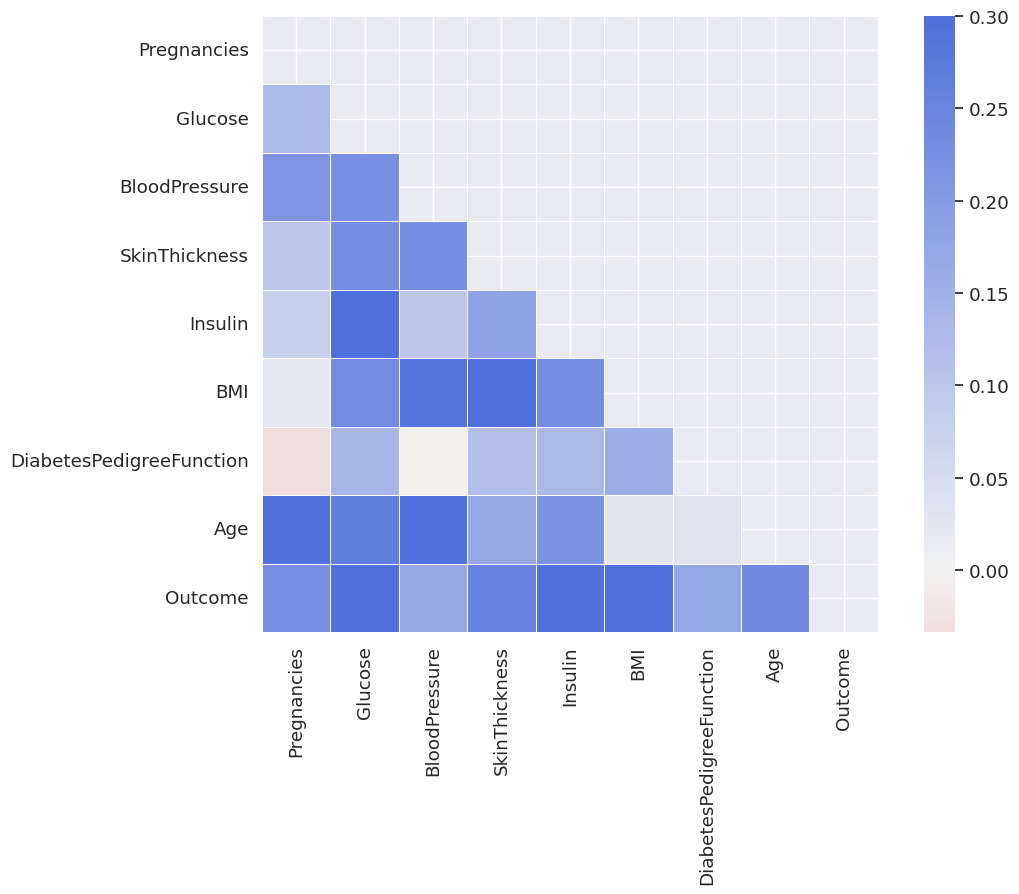

In [18]:
corr = diabetes.corr()

# Generate a mask to block out the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10,260, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0., square=True, linewidths=.5);

***
## Aim

To create a classifier for predicting whether a person has diabetes or not.

## Train-Test split

We’re going to split our data into 70% training and 30% testing sets.

In [19]:
features_train, features_test, outcome_train, outcome_test = train_test_split(
    diabetes[diabetes.columns.difference(['Outcome'])],
    diabetes['Outcome'], 
    train_size=0.7, 
    test_size=0.3, 
    random_state = 42, 
    stratify = diabetes['Outcome']
)

How many examples do we have in the training and testing sets?

In [20]:
features_train.shape

(537, 8)

In [21]:
features_test.shape

(231, 8)

## Impute missing values using median values

In [22]:
## Impute missing information
imp_median = SimpleImputer(strategy='median') 
imp_median.fit(features_train)
features_train_imp = pd.DataFrame(imp_median.transform(features_train))
features_test_imp = pd.DataFrame(imp_median.transform(features_test))
features_train_imp.columns = features_train.columns
features_test_imp.columns = features_test.columns

Confirm that we have imputed the values for BOTH training and testing datasets using the TRAINING data median!

In [23]:
features_train.head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
209,41,35.5,84.0,0.355,184.0,NaN,7,33.0
176,42,31.2,78.0,0.382,85.0,NaN,6,NaN
147,34,30.5,64.0,1.400,106.0,119.0,2,35.0
454,24,37.8,54.0,0.498,100.0,105.0,2,28.0
636,48,28.8,74.0,0.153,104.0,NaN,5,NaN


In [24]:
features_train_imp.head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
0,41.0,35.5,84.0,0.355,184.0,126.0,7.0,33.0
1,42.0,31.2,78.0,0.382,85.0,126.0,6.0,29.0
2,34.0,30.5,64.0,1.400,106.0,119.0,2.0,35.0
3,24.0,37.8,54.0,0.498,100.0,105.0,2.0,28.0
4,48.0,28.8,74.0,0.153,104.0,126.0,5.0,29.0


In [25]:
features_test.tail()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
94,21,24.7,82.0,0.761,142.0,64.0,2,18.0
437,28,29.9,75.0,0.434,147.0,NaN,5,NaN
86,45,36.6,72.0,0.178,106.0,NaN,13,54.0
221,66,31.6,90.0,0.805,158.0,NaN,2,NaN
19,32,34.6,70.0,0.529,115.0,96.0,1,30.0


In [26]:
features_test_imp.tail()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
226,21.0,24.7,82.0,0.761,142.0,64.0,2.0,18.0
227,28.0,29.9,75.0,0.434,147.0,126.0,5.0,29.0
228,45.0,36.6,72.0,0.178,106.0,126.0,13.0,54.0
229,66.0,31.6,90.0,0.805,158.0,126.0,2.0,29.0
230,32.0,34.6,70.0,0.529,115.0,96.0,1.0,30.0


In [27]:
features_train.median()

Age                          30.000
BMI                          32.400
BloodPressure                72.000
DiabetesPedigreeFunction      0.385
Glucose                     117.000
Insulin                     126.000
Pregnancies                   3.000
SkinThickness                29.000
dtype: float64

In [28]:
features_test.median()

Age                          28.000
BMI                          31.600
BloodPressure                72.000
DiabetesPedigreeFunction      0.342
Glucose                     118.000
Insulin                     120.000
Pregnancies                   3.000
SkinThickness                30.000
dtype: float64

### Standardize data ranges

In [29]:
StSc = StandardScaler()
StSc.fit(features_train_imp)
features_train_sc = StSc.transform(features_train_imp)
features_test_sc  = StSc.transform(features_test_imp)

### Check outcome

In [30]:
# 0 is normal 
# 1 is diabetes
print('count of outcome in test set')
print((outcome_test == 0).sum())
print((outcome_test != 0).sum())

# 
print('count of outcome in train set')
print((outcome_train == 0).sum())
print((outcome_train != 0).sum())

# is our train/test balanced?
print('Check on train vs test balance')
print((outcome_test != 0).sum() / (outcome_test == 0).sum())
print((outcome_train != 0).sum() / (outcome_train == 0).sum())

count of outcome in test set
150
81
count of outcome in train set
350
187
Check on train vs test balance
0.54
0.5342857142857143


## Classifiers

### k-Nearest Neighbours Classifier

This takes the nearest $k$ data points and looks at which outcome is most common in them. In the example below we look at the seven nearest neighbours, 4 of which are cats so we say that the new example is probably a cat as well.

![A way to classify a new example as a cat or not...take the average of the nearest k=7 examples. It's a cat!](../fig/50-CatKNN.jpg)


#### Let's Classify!

Train KNN classifier.

Link to [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) for students, if you'd like to look at the formulas to understand how one function can generalise two distance metrics.

In [31]:
# the default settings are metric='minkowski' and p = 2
# , which is the same as the standard Euclidean metric
# p = 1 gets us manhattan distance

cf_knn= KNeighborsClassifier(metric='minkowski')

# use GridSeachCV to test how many neighbors are optimal
cf_knn_gscv = GridSearchCV(
    cf_knn,
    # test from 1 to 50 neighbors 
    param_grid={'n_neighbors': np.arange(1, 51)},
    # use 5xfold cross-validation
    cv=5,
    # use f1 as error metric
    scoring = 'f1',
    return_train_score=True
)

fit_knn = cf_knn_gscv.fit(features_train_sc, outcome_train)

Explore the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for other error metrics we could have used.

In [32]:
# Look at the cross-validation results
knn_results = pd.DataFrame.from_dict(fit_knn.cv_results_)
knn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002653,0.003430,0.004816,0.001946,1,{'n_neighbors': 1},0.571429,0.640000,0.623377,0.500000,...,0.556513,0.073053,40,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000526,0.000005,0.003017,0.000039,2,{'n_neighbors': 2},0.550725,0.474576,0.557377,0.436364,...,0.466031,0.089967,50,0.692982,0.747899,0.717949,0.739496,0.744770,0.728619,0.020663
2,0.000539,0.000043,0.003020,0.000071,3,{'n_neighbors': 3},0.627907,0.641026,0.640000,0.606061,...,0.616332,0.027843,3,0.793220,0.831081,0.784566,0.800000,0.804054,0.802584,0.015705
3,0.000541,0.000030,0.003039,0.000051,4,{'n_neighbors': 4},0.563380,0.523077,0.593750,0.456140,...,0.534412,0.046080,49,0.688259,0.711462,0.671875,0.692015,0.734375,0.699597,0.021470
4,0.000574,0.000047,0.003160,0.000171,5,{'n_neighbors': 5},0.617284,0.619718,0.605263,0.558824,...,0.591693,0.027866,12,0.744681,0.759582,0.724138,0.760000,0.765517,0.750784,0.015011


In [33]:
fit_knn.best_estimator_.n_neighbors

9

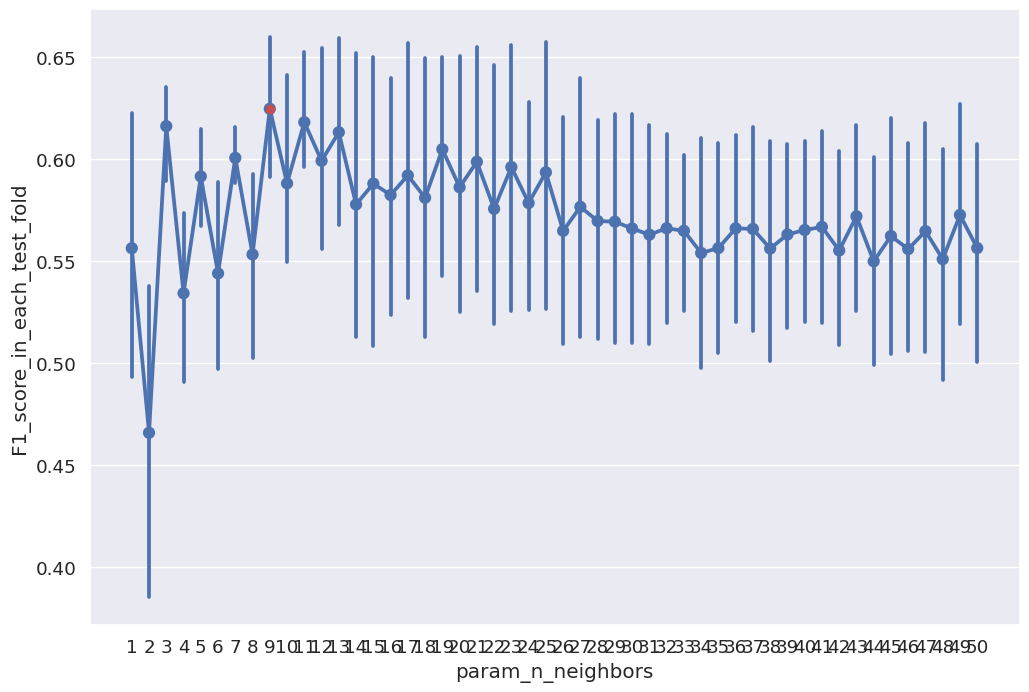

In [34]:
split_cols = knn_results.filter(regex='split.*test_score').columns
knn_cv_scores = knn_results.melt(
    id_vars='param_n_neighbors', 
    value_vars=split_cols
).rename(columns={"value": "F1_score_in_each_test_fold"})

sns.pointplot(
    x="param_n_neighbors",
    y="F1_score_in_each_test_fold",
    data = knn_cv_scores
)

best_n = fit_knn.best_estimator_.n_neighbors
plt.scatter(
    x = best_n - 1,
    y = knn_cv_scores.loc[knn_cv_scores['param_n_neighbors'] == best_n, 'F1_score_in_each_test_fold'].mean(),
    color = 'r',
    # plots point on top of other plot
    zorder = 10
);

!!! challenge "Challenge"
    Do you think this is the optimal solution?
    
    ??? "Solution"
        Probably not, since the performance of the classifier 
        after a certain number of neighbors (~9 - 30) doesn't 
        really seem to improve that much

In [35]:
# Use trained classifier to predict outcome for training and test
knn_outcome_pred_class_train = fit_knn.predict(features_train_sc)
knn_outcome_pred_class_test = fit_knn.predict(features_test_sc)


# get probabilities out
def model_probabilities(model = fit_knn, dataset = features_train_sc):
    return [p1 for p0, p1 in  model.predict_proba(dataset)]

knn_outcome_pred_prob_train = model_probabilities(model = fit_knn, dataset = features_train_sc)
knn_outcome_pred_prob_test = model_probabilities(model = fit_knn, dataset = features_test_sc)

#### Classifier Diagnostics/evaluation
So how well did the classifier do? Let's define a function to generate a confusion matrix:

In [36]:
# define custom confusion matrix function
def confmatrix(truth = outcome_train, 
               prediction = knn_outcome_pred_class_train):
    df = pd.DataFrame(confusion_matrix(truth, prediction))
    #Total sum per row: 
    df.loc['Total',:]= df.sum(axis=0)
    # assign multi index label on the left of rows
    df.index = pd.MultiIndex.from_tuples([('Truth', 0), ('Truth', 1), ('Total', '')])
    #Total sum per column: 
    df.loc[:,'Total'] = df.sum(axis=1)
    # assign multi index label at the top of the column names
    df.columns = pd.MultiIndex.from_tuples([('Prediction', 0), ('Prediction', 1), ('Total', '')])
    return(df)

Assess performance on the training set:

In [37]:
confmatrix(truth = outcome_train, prediction = knn_outcome_pred_class_train)

Prediction         Total
                 0      1       
Truth 0      307.0   43.0  350.0
      1       61.0  126.0  187.0
Total        368.0  169.0  537.0

In [38]:
confmatrix(truth = outcome_test, prediction = knn_outcome_pred_class_test)

Prediction        Total
                 0     1       
Truth 0      127.0  23.0  150.0
      1       36.0  45.0   81.0
Total        163.0  68.0  231.0

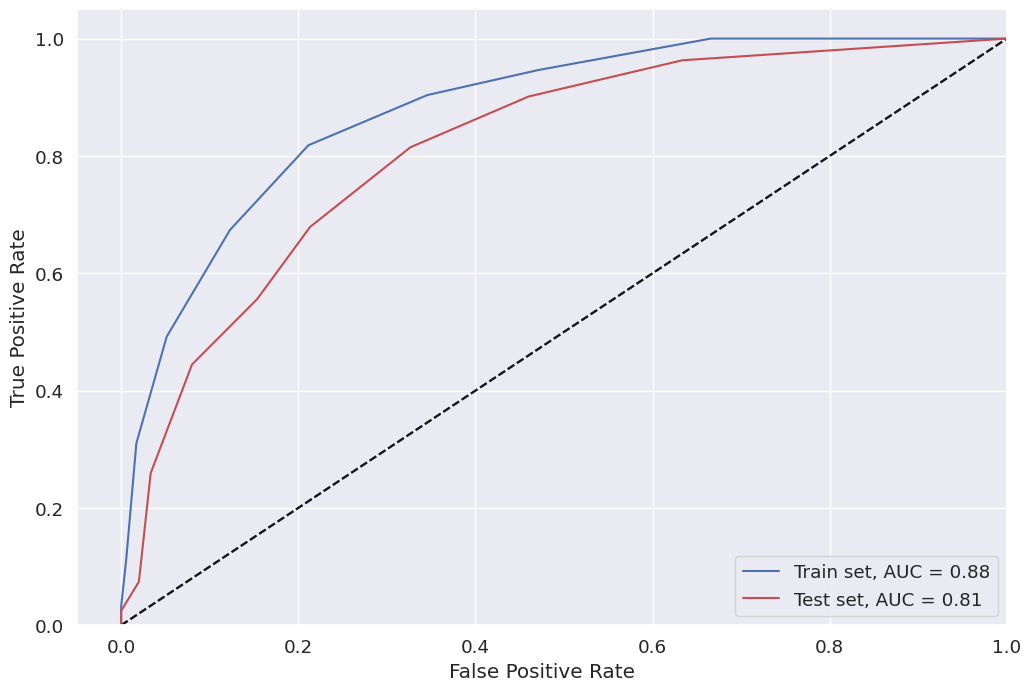

In [39]:
# define a function to plot an ROC curve
def plot_ROC(truth = outcome_train, prediction1 = knn_outcome_pred_prob_train, 
             col = 'b', test=False):
    fpr, tpr, _ = roc_curve(truth, prediction1)
    AUC = roc_auc_score(truth, prediction1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    label_plot = f'Train set, AUC = {AUC:.2f}'
    if test:
        label_plot = f'Test set, AUC = {AUC:.2f}'
    plt.plot(fpr, tpr, label=label_plot, color = col)
    plt.legend(loc="lower right");


# plot the roc curves
# training in blue
plot_ROC(truth = outcome_train, prediction1 = knn_outcome_pred_prob_train, col = 'b')
# test in red
plot_ROC(truth = outcome_test, prediction1 = knn_outcome_pred_prob_test, col = 'r', test=True)

!!! challenge "Challenge"
    How well do you think this model generalised?
    
    ??? "Solution"
        While the overall performance of the model is not very good,
        it does generalise well, as the difference between the
        training and test performance is small.

### Naive Bayes Classifier

A Naïve Bayes classifier assumes that each of your columns are independent (uncorrelated with each other). It works out a probability that your example is a cat by counting the fraction of cats that had that value in each column, multiplying the values together and then multiplying again by what fraction of your training examples were cats. This is just writing out bayes rule of conditional probability and simplifying it for independent columns.

$$
p(\text{Cat}| x_\text{new})=\frac{p(\text{Cat})p(x_\text{new}|\text{Cat})}{p(\text{Cat})p(x_\text{new}|\text{Cat})+p(\text{Not Cat})p(x_\text{new}|\text{Not Cat})}
$$

In practice your columns are probably not independent, but we still use it anyway and it's usually ok, providing we only care about the label and not the probability it spits out.  

Continuous variables have to be somehow turned into discrete variables before you can use this technique, but most algorithms do this for you automatically.

#### Naive Bayes example

Let's say we're trying to predict if someone is a clown (🤡) or not (😀): we have data about their hair colour (Red or Other),
shoe size (Big or Small) and car size (Tiny or Large).

| Hair     |    Shoe size   |     Car size     |  Clown    |
|----------|----------------|------------------|-----------|
|Red       |     Big        |        Large     |    Yes    |
|Red       |     Small      |        Tiny      |    Yes    |
| Red      |      Big       |         Large    |    No     |
|Other     |     Small      |        Tiny      |    No     |
|  Other   |       Big      |        Large     |    Yes    |

Using these variables to predict if someone is a clown, we would have:

$$
p(\text{Clown} | \text{Hair, Shoes, Car}) = 
    \frac{p(\text{Clown}) p(\text{Hair} | \text{Clown}) p(\text{Shoes} | \text{Clown}) p(\text{Car} | \text{Clown})}
        {\text{Normalizing denominator}}
$$

where

$$
\begin{align}
\text{Normalizing denominator} = & 
    p(\text{Clown}) p(\text{Hair} | \text{Clown}) p(\text{Shoes} | \text{Clown}) p(\text{Car} | \text{Clown}) + \\
    & p(\text{Not clown}) p(\text{Hair} | \text{Not clown}) p(\text{Shoes} | \text{Not clown}) p(\text{Car} | \text{Not clown})
\end{align}
$$

If we come across a new person with **Red hair**, **Big shoes**, and a **Tiny car**, we can calculate the probability that they are a clown:

The overall probabilities are $p(\text{Clown}) = \frac{3}{5}, p(\text{Not clown}) = \frac{2}{5}$.

Then for the conditional probabilities we have

* $p(\text{Red hair} | \text{Clown}) = \frac{2}{3}$, $p(\text{Red hair} | \text{Not clown}) = \frac{1}{2}$
* $p(\text{Big shoes} | \text{Clown}) = \frac{2}{3}$, $p(\text{Big shoes} | \text{Not clown}) = \frac{1}{2}$
* $p(\text{Tiny car} | \text{Clown}) = \frac{1}{3}$, $p(\text{Tiny car} | \text{Not clown}) = \frac{1}{2}$


So the numerator works out to

$$
\frac{3}{5} \times \frac{2}{3} \times \frac{2}{3} \times \frac{1}{3} = \frac{4}{45}
$$

With a bit of extra work, we can work out the denominator as $\frac{5}{36}$, giving us

$$
p(\text{Clown} | \text{Red hair, Big shoes, Tiny car}) = \frac{4/45}{5/36} = \frac{16}{25} =  0.64
$$

#### Let's Classify!
Train Naive Bayes classifier

In [40]:
from sklearn.naive_bayes import GaussianNB
cf_gnb = GaussianNB()


cf_gnb_gscv = GridSearchCV(cf_gnb, 
                           {'var_smoothing' : [1e-09]},
                           # use 5xfold cross-validation
                           cv=5,
                           # use f1 as error metric
                           scoring = 'f1')

fit_gnb = cf_gnb_gscv.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [41]:
gnb_train_pred_class = cf_gnb_gscv.predict(features_train_sc)
gnb_test_pred_class = cf_gnb_gscv.predict(features_test_sc)

gnb_pred_prob_train = model_probabilities(model = cf_gnb_gscv, dataset=features_train_sc)
gnb_pred_prob_test = model_probabilities(model = cf_gnb_gscv, dataset=features_test_sc)

#### Classifier Diagnostics
So how well did it go?

In [42]:
# print matrix for predictions on training and testing
print("Training set")
confmatrix(truth = outcome_train, prediction = gnb_train_pred_class)

Training set


Prediction         Total
                 0      1       
Truth 0      297.0   53.0  350.0
      1       77.0  110.0  187.0
Total        374.0  163.0  537.0

In [43]:
print("\nTesting set")
confmatrix(truth = outcome_test, prediction = gnb_test_pred_class)


Testing set


Prediction        Total
                 0     1       
Truth 0      121.0  29.0  150.0
      1       34.0  47.0   81.0
Total        155.0  76.0  231.0

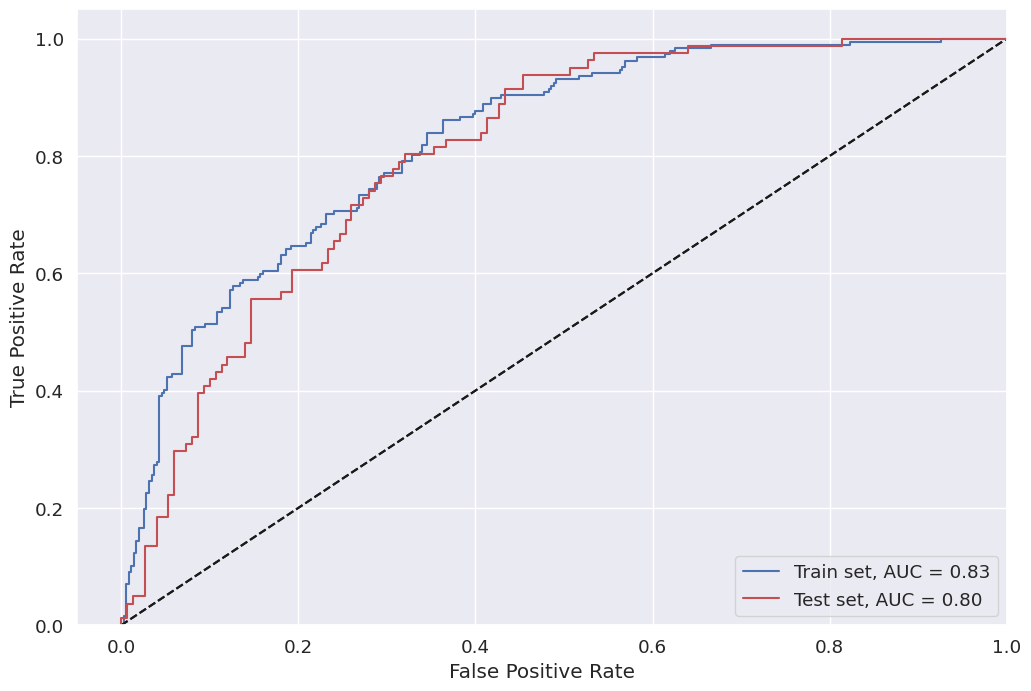

In [44]:
# plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = gnb_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = gnb_pred_prob_test, col = 'r', test=True)

### Regularized Logistic Classifier

This fits a logistic regression to the probability of receiving a class label of 1 or 0. Regularisation (hopefully) stops it from overfitting. 

#### Let's Classify!
Train Regularized Logistic classifier. 

There are several algorithms to do this accessible in scikit-learn, and we will use the one that uses the saga solver. 

In [45]:
from sklearn.linear_model import LogisticRegression
# class_weight balanced will use the values of y to automatically adjust weights inversely 
# proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)
# multi_class='ovr' - a binary problem is fit for each label
cf_rlc = LogisticRegression(random_state=42, solver='saga',
                            multi_class='ovr')

# test different penalty and class weight parameters -
# define this as a dictionary to make subsequent plotting easier
rlc_dict = {
    'penalty': ['l1', 'l2'],
    # for proper ENET
    # 'penalty': ['elasticnet'], 
    'class_weight': [None, 'balanced']
}
    # l1_ratio with saga implements a proper EN, but doesn't work ATM b/c pf a
    # l1_ratio not a recognised parameter issue
    # 'l1_ratio': np.linspace(start=0.01, stop=0.99, num=8)
# }

# use GridSeachCV to which form of regularisation is optimal
cf_rlc_gscv = GridSearchCV(
    cf_rlc,
    rlc_dict,
    # use 5xfold cross-validation
    cv=5,
    # use AUC as error metric
    scoring = 'f1'
)
# fit model on training data
fit_rlc = cf_rlc_gscv.fit(features_train_sc, outcome_train)

In [46]:
# what is the best estimator?
fit_rlc.best_estimator_

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42,
                   solver='saga')

Use trained classifier to predict outcome for training and test sets

In [47]:
rlc_train_pred_class = fit_rlc.predict(features_train_sc)
rlc_test_pred_class = fit_rlc.predict(features_test_sc)

rlc_pred_prob_train = model_probabilities(model = cf_rlc_gscv, dataset=features_train_sc)
rlc_pred_prob_test = model_probabilities(model = cf_rlc_gscv, dataset=features_test_sc)

#### Classifier evaluation
So how well did the classifier do?

In [48]:
# print matrix for predictions on training and testing
print("Training set")
confmatrix(truth = outcome_train, prediction = rlc_train_pred_class)

Training set


Prediction         Total
                 0      1       
Truth 0      279.0   71.0  350.0
      1       51.0  136.0  187.0
Total        330.0  207.0  537.0

In [49]:
print("\nTesting set")
confmatrix(truth = outcome_test, prediction = rlc_test_pred_class)


Testing set


Prediction        Total
                 0     1       
Truth 0      119.0  31.0  150.0
      1       24.0  57.0   81.0
Total        143.0  88.0  231.0

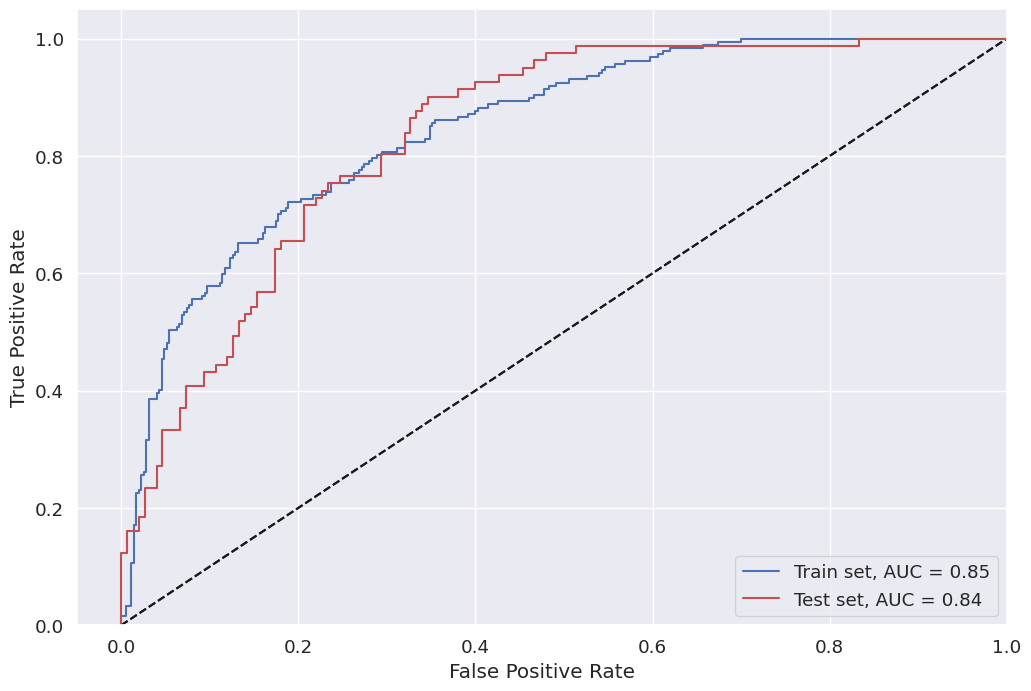

In [50]:
# plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = rlc_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = rlc_pred_prob_test, col = 'r', test=True)

### Decision Trees

A decision tree 🌳 picks the best split in the data greedily for each feature and basically makes a flowchart to follow with a new data point to say what you should classify it as. This makes them easy to understand, but also usually not very accurate. 

#### Let's Classify!
Train Decision Tree classifier.

To see how the gini coefficient vs entropy are calculated see [here](https://scikit-learn.org/stable/modules/tree.html#classification-criteria). 

In [51]:
from sklearn.tree import DecisionTreeClassifier
cf_dtc = DecisionTreeClassifier(random_state= 42)
dtc_dict = {
    # function to measure quality of split
    'criterion': ['gini', 'entropy'],
    # The minimum number of samples required to split an internal node
    'min_samples_split': np.arange(start = 2, stop = 20, step = 3),
    # The minimum number of samples required to be at a leaf node
    'min_samples_leaf': np.arange(start = 1, stop = 10, step = 2)}


cf_dtc_gscv = GridSearchCV(cf_dtc,
                           dtc_dict,
                           # use 5xfold cross-validation
                           cv=5,
                           # use AUC as error metric
                           scoring = 'f1')
    
# fit the model on the training data
fit_dtc = cf_dtc_gscv.fit(features_train_sc, outcome_train)

# what were the best parameters?
fit_dtc.best_estimator_

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=9, random_state=42)

Use trained classifier to predict outcome for test-set

Training set
        Prediction         Total
                 0      1       
Truth 0      320.0   30.0  350.0
      1       54.0  133.0  187.0
Total        374.0  163.0  537.0

Testing set
        Prediction        Total
                 0     1       
Truth 0      131.0  19.0  150.0
      1       42.0  39.0   81.0
Total        173.0  58.0  231.0


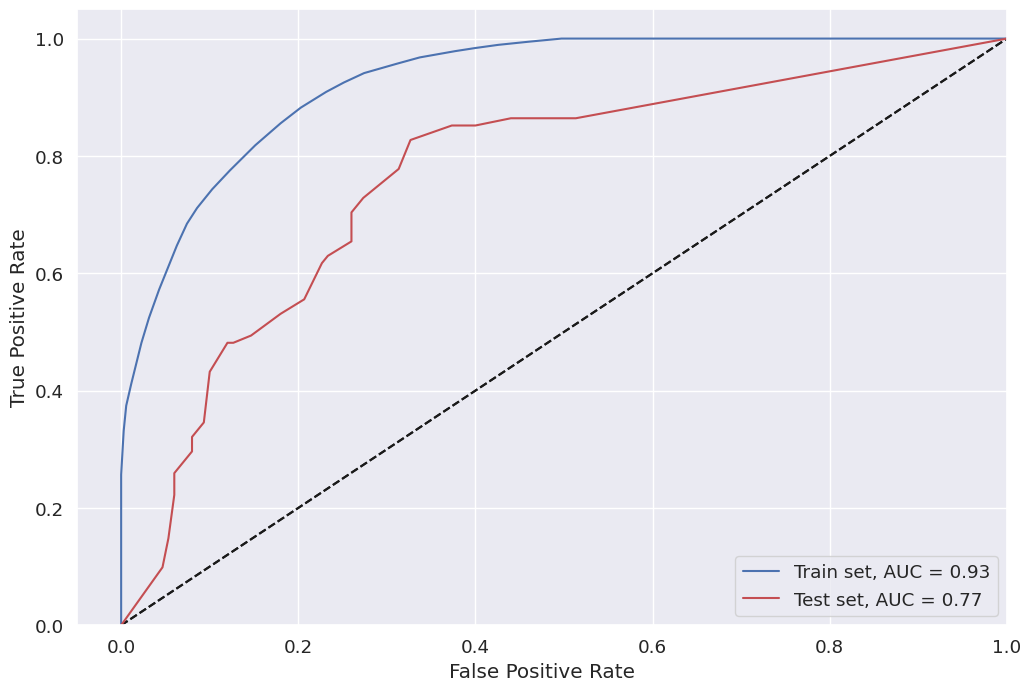

In [52]:
dtc_train_pred_class = fit_dtc.predict(features_train_sc)
dtc_test_pred_class = fit_dtc.predict(features_test_sc)

dtc_pred_prob_train = model_probabilities(model = cf_dtc_gscv, dataset=features_train_sc)
dtc_pred_prob_test = model_probabilities(model = cf_dtc_gscv, dataset=features_test_sc)


# # print matrix for predictions on training and testing
print("Training set")
print(confmatrix(truth = outcome_train, prediction = dtc_train_pred_class))
print("\nTesting set")
print(confmatrix(truth = outcome_test, prediction = dtc_test_pred_class))



# # plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = dtc_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = dtc_pred_prob_test, col = 'r', test=True)

We can also plot the decision tree

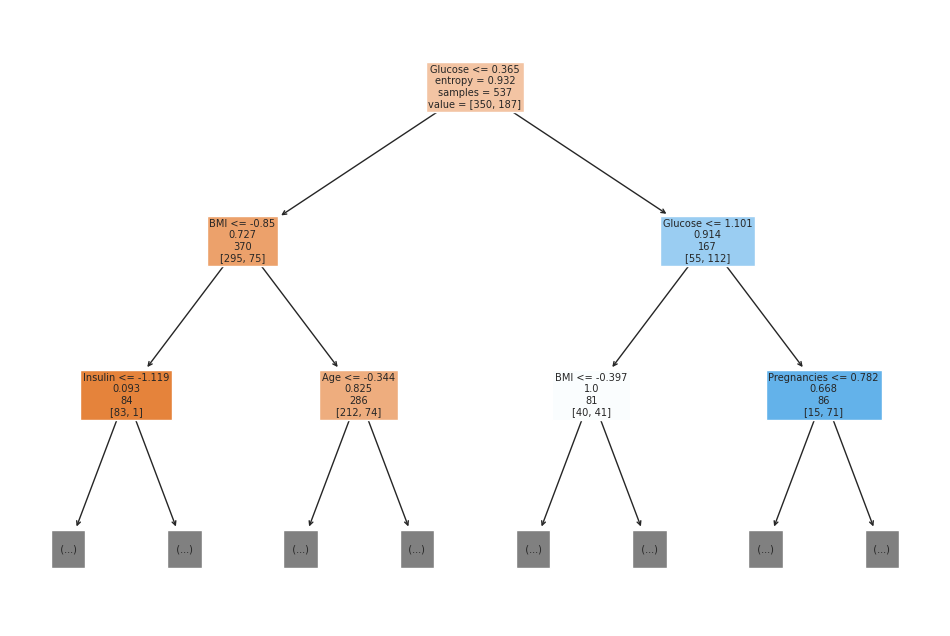

In [53]:
from sklearn import tree

tree.plot_tree(fit_dtc.best_estimator_, max_depth=2,
               feature_names=features_train.columns,
               label='root',
               filled=True); 

!!! challenge "Challenge"
    Do you think this model is fit well?
    
    ??? "Solution"
        No, the tree has overfit

### Random Forest Classifier
A random decision tree is where you make a decision tree but only train it on either:

- (a) a random sample of the available data or 
- (b) a random sample of the available features or 
- (c) both.

A random forest is a whole bunch of these averaged together. 

Turns out these do pretty good and are used all over the place. But because they're the average of so many different models it's hard to get an understanding about it. It's basically a black box that predicts well.

In [54]:
from sklearn.ensemble import RandomForestClassifier
cf_rfc = RandomForestClassifier(random_state=42)
 
rf_dict = {
    # The number of trees in the forest
    'n_estimators': np.arange(10,150,25), 
    # quality of a split
    'criterion': ['entropy'],
    # The minimum number of samples required to split an internal node
    'min_samples_split': np.arange(start = 2, stop = 20, step = 5),
    # The minimum number of samples required to be at a leaf node
    'min_samples_leaf': np.arange(start = 1, stop = 3, step = 1),
    # the number of features to consider when looking for the best split
    # max_features=sqrt(n_features)/max_features=log2(n_features)
    'max_features': ['sqrt'],
    'class_weight': ['balanced_subsample', None]
}

# use GridSeachCV to which form of regularisation is optimal
cf_rf_gscv = GridSearchCV(cf_rfc,
                           rf_dict,
                           # use 5xfold cross-validation
                           cv=5,
                           # use AUC as error metric
                           scoring = 'f1')

# fit model on training data
fit_rf = cf_rf_gscv.fit(features_train_sc, outcome_train)

# what were the best parameters?
fit_rf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_samples_split=12, n_estimators=110, random_state=42)

Use trained classifier to predict outcome for test-set

Training set
        Prediction         Total
                 0      1       
Truth 0      331.0   19.0  350.0
      1       10.0  177.0  187.0
Total        341.0  196.0  537.0

Testing set
        Prediction        Total
                 0     1       
Truth 0      123.0  27.0  150.0
      1       25.0  56.0   81.0
Total        148.0  83.0  231.0


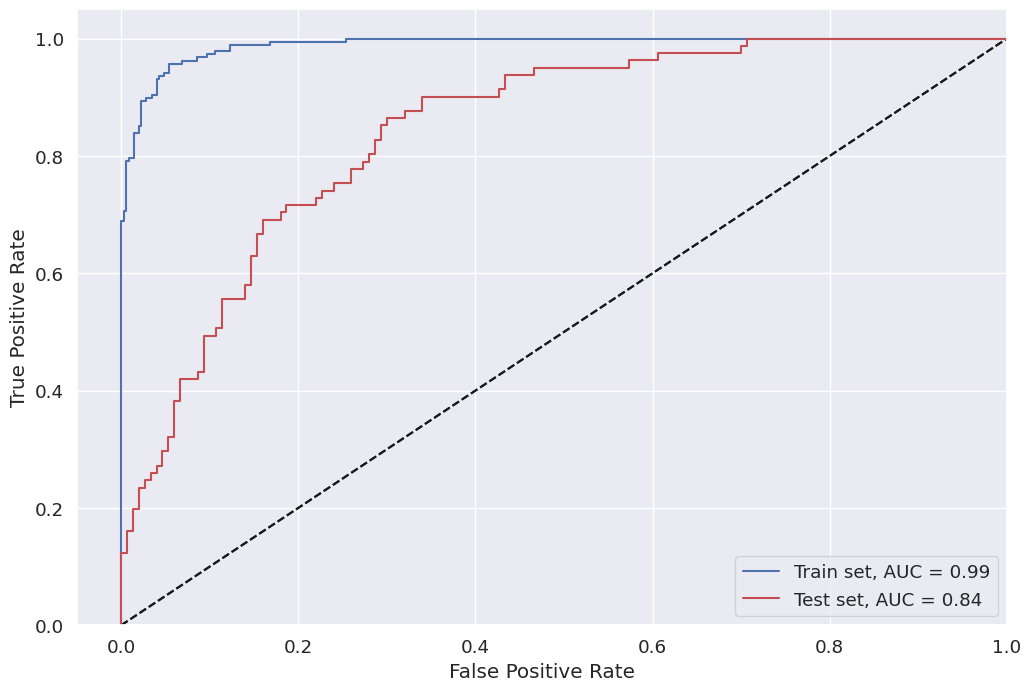

In [55]:
rf_train_pred_class = cf_rf_gscv.predict(features_train_sc)
rf_test_pred_class = cf_rf_gscv.predict(features_test_sc)

rf_pred_prob_train = model_probabilities(model = cf_rf_gscv, dataset=features_train_sc)
rf_pred_prob_test = model_probabilities(model = cf_rf_gscv, dataset=features_test_sc)


# print matrix for predictions on training and testing
print("Training set")
print(confmatrix(truth = outcome_train, prediction = rf_train_pred_class))
print("\nTesting set")
print(confmatrix(truth = outcome_test, prediction = rf_test_pred_class))


# plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = rf_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = rf_pred_prob_test, col = 'r', test=True);

### Support Vector Machine
A support vector machine tries to find the data points right on the boundary between the two classes (the "support vectors") and then uses them to define a maximum margin boundary.

![A linear Support Vector Machine for Cats](../fig/50-CatSVM.jpg)

#### Let's Classify!
Train SVM

In [56]:
from sklearn import svm
cf_svm = svm.SVC(random_state=42, probability=True, 
                 # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
                 # 1 / (n_features * X.var()) 
                gamma = 'scale')

cf_svm_gscv_lin = GridSearchCV(cf_svm,
                           {'kernel': ['linear']},
                           # use 5xfold cross-validation
                           cv=5,
                           # use F1 score as error metric
                           scoring = 'f1')

fit_svm_lin = cf_svm_gscv_lin.fit(features_train_sc, outcome_train)

# use GridSeachCV to which form of regularisation is optimal
cf_svm_gscv_rad = GridSearchCV(cf_svm,
                           {'kernel': ['rbf']},
                           # use 5xfold cross-validation
                           cv=5,
                           # use F1 as error metric
                           scoring = 'f1')

fit_svm_rbf = cf_svm_gscv_rad.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [57]:
fit_svm_lin.best_estimator_

SVC(kernel='linear', probability=True, random_state=42)

In [58]:
fit_svm_rbf.best_estimator_

SVC(probability=True, random_state=42)

Training set
        Prediction         Total
                 0      1       
Truth 0      317.0   33.0  350.0
      1       81.0  106.0  187.0
Total        398.0  139.0  537.0

Testing set
        Prediction        Total
                 0     1       
Truth 0      130.0  20.0  150.0
      1       43.0  38.0   81.0
Total        173.0  58.0  231.0


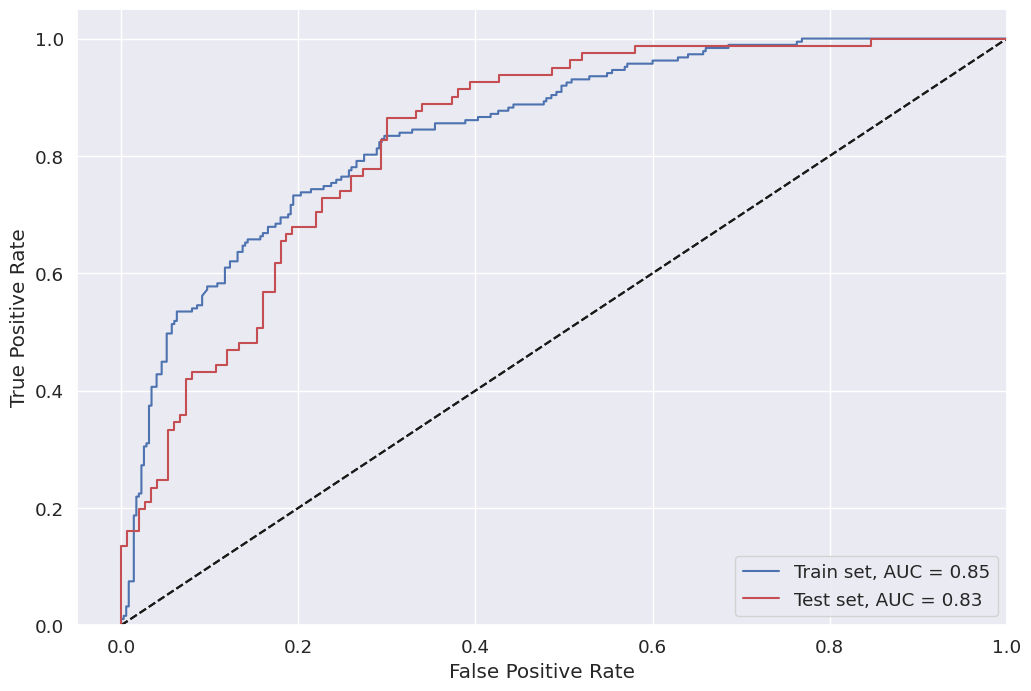

In [59]:
svm_l_train_pred_class = cf_svm_gscv_lin.predict(features_train_sc)
svm_l_test_pred_class = cf_svm_gscv_lin.predict(features_test_sc)

svm_l_pred_prob_train = model_probabilities(model = cf_svm_gscv_lin, dataset=features_train_sc)
svm_l_pred_prob_test = model_probabilities(model = cf_svm_gscv_lin, dataset=features_test_sc)


# print matrix for predictions on training and testing
print("Training set")
print(confmatrix(truth = outcome_train, prediction = svm_l_train_pred_class))
print("\nTesting set")
print(confmatrix(truth = outcome_test, prediction = svm_l_test_pred_class))



# plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = svm_l_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = svm_l_pred_prob_test, col = 'r', test=True)

Training set
        Prediction         Total
                 0      1       
Truth 0      327.0   23.0  350.0
      1       62.0  125.0  187.0
Total        389.0  148.0  537.0

Testing set
        Prediction        Total
                 0     1       
Truth 0      131.0  19.0  150.0
      1       40.0  41.0   81.0
Total        171.0  60.0  231.0


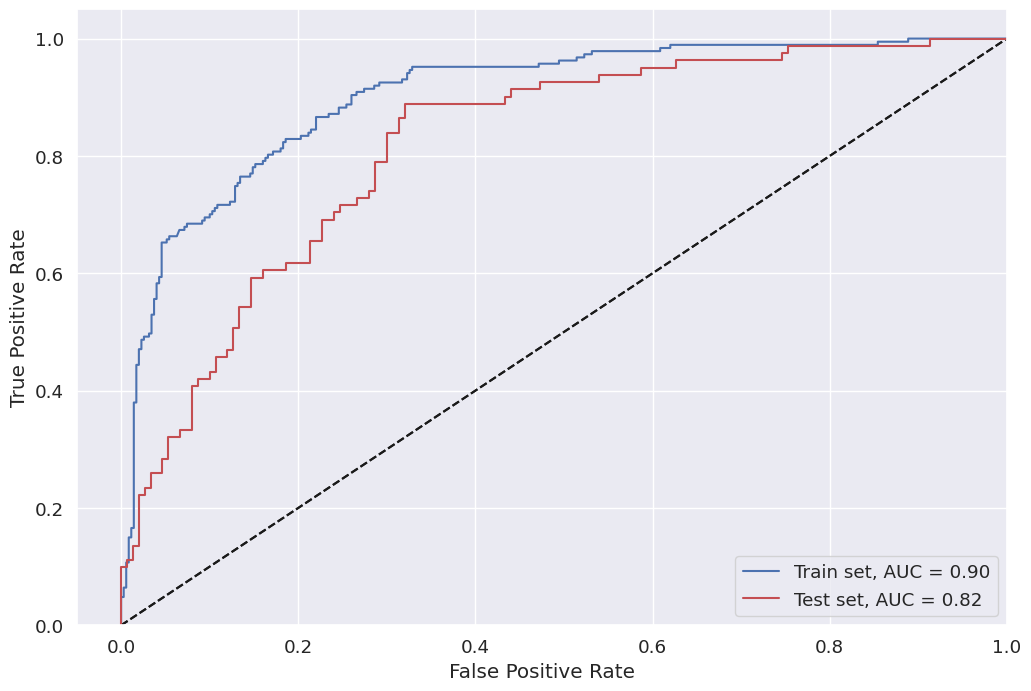

In [60]:
svm_r_train_pred_class = cf_svm_gscv_rad.predict(features_train_sc)
svm_r_test_pred_class = cf_svm_gscv_rad.predict(features_test_sc)

svm_r_pred_prob_train = model_probabilities(model = cf_svm_gscv_rad, dataset=features_train_sc)
svm_r_pred_prob_test = model_probabilities(model = cf_svm_gscv_rad, dataset=features_test_sc)


# print matrix for predictions on training and testing
print("Training set")
print(confmatrix(truth = outcome_train, prediction = svm_r_train_pred_class))
print("\nTesting set")
print(confmatrix(truth = outcome_test, prediction = svm_r_test_pred_class))



# plot the roc curves
plot_ROC(truth = outcome_train, prediction1 = svm_r_pred_prob_train, col = 'b')
plot_ROC(truth = outcome_test, prediction1 = svm_r_pred_prob_test, col = 'r', test=True)

## Compare all the classifiers

In [61]:
evaluations = ['Misclassification rate', 'Sensitivity', 'Specificity', 'AUC']
pretrained_models = {'k Nearest Neighbours':cf_knn_gscv, 
                     'Naive Bayes':cf_gnb_gscv, 
                     'Regularised Logistic Classifier':cf_rlc_gscv, 
                     'Decision Tree':cf_dtc_gscv, 
                     'Random Forest':cf_rf_gscv, 
                     'Linear SVM':cf_svm_gscv_lin,
                     'Radial SVM':cf_svm_gscv_rad}
comparison_stats = pd.DataFrame(index = pretrained_models.keys(), columns=evaluations)
for method, model in pretrained_models.items():
    outcome_pred_class = model.predict(features_test_sc)
    outcome_pred_prob = model_probabilities(model = model, dataset = features_test_sc)
    AUC = roc_auc_score(outcome_test, outcome_pred_prob)
    conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
    # in this case 0-0 is negatives
    # 1-1 is diabetes
    TP = conf_mat[1,1]
    FP = conf_mat[0,1]
    TN = conf_mat[0,0]
    FN = conf_mat[1,0]
    
    comparison_stats.loc[method,'Misclassification rate']  = 1. - accuracy_score(outcome_test, outcome_pred_class)
    # sensitivity == recall
    comparison_stats.loc[method,'Sensitivity'] = TP/(TP + FN)
    comparison_stats.loc[method,'Specificity'] = TN/(TN + FP)
    comparison_stats.loc[method,'Precision'] = TP/(TP + FP)
    comparison_stats.loc[method,'Accuracy'] = (TP + TN)/(TP + FP + TN + FN)
    comparison_stats.loc[method,'FDR'] = FP/(FP + TP)
    comparison_stats.loc[method,'F1'] = 2 * TP/(2 * TP + FP + FN)
    comparison_stats.loc[method,'AUC'] = AUC

In [62]:
comparison_stats.round(decimals=3).sort_values(by = 'AUC', ascending=False)

,Misclassification rate,Sensitivity,Specificity,AUC,Precision,Accuracy,FDR,F1
Random Forest,0.225108,0.691358,0.82,0.84428,0.675,0.775,0.325,0.683
Regularised Logistic Classifier,0.238095,0.703704,0.793333,0.836543,0.648,0.762,0.352,0.675
Linear SVM,0.272727,0.469136,0.866667,0.832757,0.655,0.727,0.345,0.547
Radial SVM,0.255411,0.506173,0.873333,0.817531,0.683,0.745,0.317,0.582
k Nearest Neighbours,0.255411,0.555556,0.846667,0.813827,0.662,0.745,0.338,0.604
Naive Bayes,0.272727,0.580247,0.806667,0.803704,0.618,0.727,0.382,0.599
Decision Tree,0.264069,0.481481,0.873333,0.767202,0.672,0.736,0.328,0.561


In [63]:
comparison_stats.round(decimals=3).sort_values(by = 'Misclassification rate', ascending=False)

,Misclassification rate,Sensitivity,Specificity,AUC,Precision,Accuracy,FDR,F1
Naive Bayes,0.272727,0.580247,0.806667,0.803704,0.618,0.727,0.382,0.599
Linear SVM,0.272727,0.469136,0.866667,0.832757,0.655,0.727,0.345,0.547
Decision Tree,0.264069,0.481481,0.873333,0.767202,0.672,0.736,0.328,0.561
k Nearest Neighbours,0.255411,0.555556,0.846667,0.813827,0.662,0.745,0.338,0.604
Radial SVM,0.255411,0.506173,0.873333,0.817531,0.683,0.745,0.317,0.582
Regularised Logistic Classifier,0.238095,0.703704,0.793333,0.836543,0.648,0.762,0.352,0.675
Random Forest,0.225108,0.691358,0.82,0.84428,0.675,0.775,0.325,0.683


In [64]:
comparison_stats.round(decimals=3).sort_values(by = 'Sensitivity', ascending=False)

,Misclassification rate,Sensitivity,Specificity,AUC,Precision,Accuracy,FDR,F1
Regularised Logistic Classifier,0.238095,0.703704,0.793333,0.836543,0.648,0.762,0.352,0.675
Random Forest,0.225108,0.691358,0.82,0.84428,0.675,0.775,0.325,0.683
Naive Bayes,0.272727,0.580247,0.806667,0.803704,0.618,0.727,0.382,0.599
k Nearest Neighbours,0.255411,0.555556,0.846667,0.813827,0.662,0.745,0.338,0.604
Radial SVM,0.255411,0.506173,0.873333,0.817531,0.683,0.745,0.317,0.582
Decision Tree,0.264069,0.481481,0.873333,0.767202,0.672,0.736,0.328,0.561
Linear SVM,0.272727,0.469136,0.866667,0.832757,0.655,0.727,0.345,0.547


In [65]:
comparison_stats.round(decimals=3).sort_values(by = 'Specificity', ascending=False)

,Misclassification rate,Sensitivity,Specificity,AUC,Precision,Accuracy,FDR,F1
Decision Tree,0.264069,0.481481,0.873333,0.767202,0.672,0.736,0.328,0.561
Radial SVM,0.255411,0.506173,0.873333,0.817531,0.683,0.745,0.317,0.582
Linear SVM,0.272727,0.469136,0.866667,0.832757,0.655,0.727,0.345,0.547
k Nearest Neighbours,0.255411,0.555556,0.846667,0.813827,0.662,0.745,0.338,0.604
Random Forest,0.225108,0.691358,0.82,0.84428,0.675,0.775,0.325,0.683
Naive Bayes,0.272727,0.580247,0.806667,0.803704,0.618,0.727,0.382,0.599
Regularised Logistic Classifier,0.238095,0.703704,0.793333,0.836543,0.648,0.762,0.352,0.675


In [66]:
comparison_stats.round(decimals=3).sort_values(by = 'F1', ascending=False)

,Misclassification rate,Sensitivity,Specificity,AUC,Precision,Accuracy,FDR,F1
Random Forest,0.225108,0.691358,0.82,0.84428,0.675,0.775,0.325,0.683
Regularised Logistic Classifier,0.238095,0.703704,0.793333,0.836543,0.648,0.762,0.352,0.675
k Nearest Neighbours,0.255411,0.555556,0.846667,0.813827,0.662,0.745,0.338,0.604
Naive Bayes,0.272727,0.580247,0.806667,0.803704,0.618,0.727,0.382,0.599
Radial SVM,0.255411,0.506173,0.873333,0.817531,0.683,0.745,0.317,0.582
Decision Tree,0.264069,0.481481,0.873333,0.767202,0.672,0.736,0.328,0.561
Linear SVM,0.272727,0.469136,0.866667,0.832757,0.655,0.727,0.345,0.547


In [67]:
def rearrange_df(df):
    out_df = (
        df.copy()
        .reset_index()
        .melt(
            id_vars='index',
            value_vars=df.columns.values.tolist(),
            var_name='metric',
            value_name='number'
        )
        .sort_values('number')
    )
    out_df['index'] = out_df['index'].astype(str)
    out_df= out_df.rename(columns={'index':'model_features'})
    return out_df

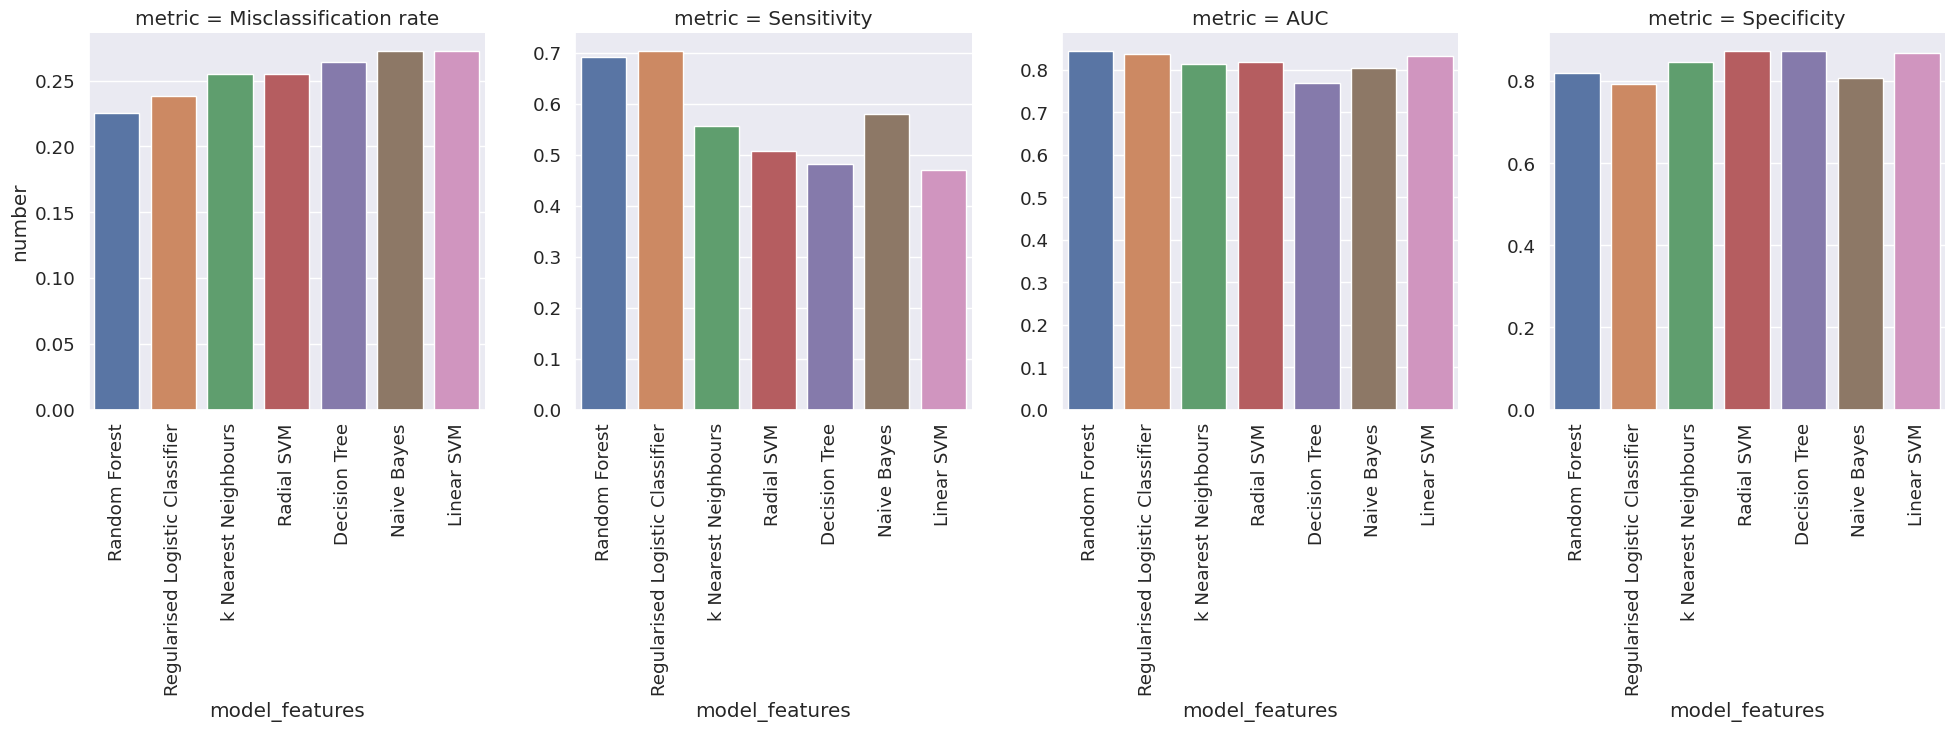

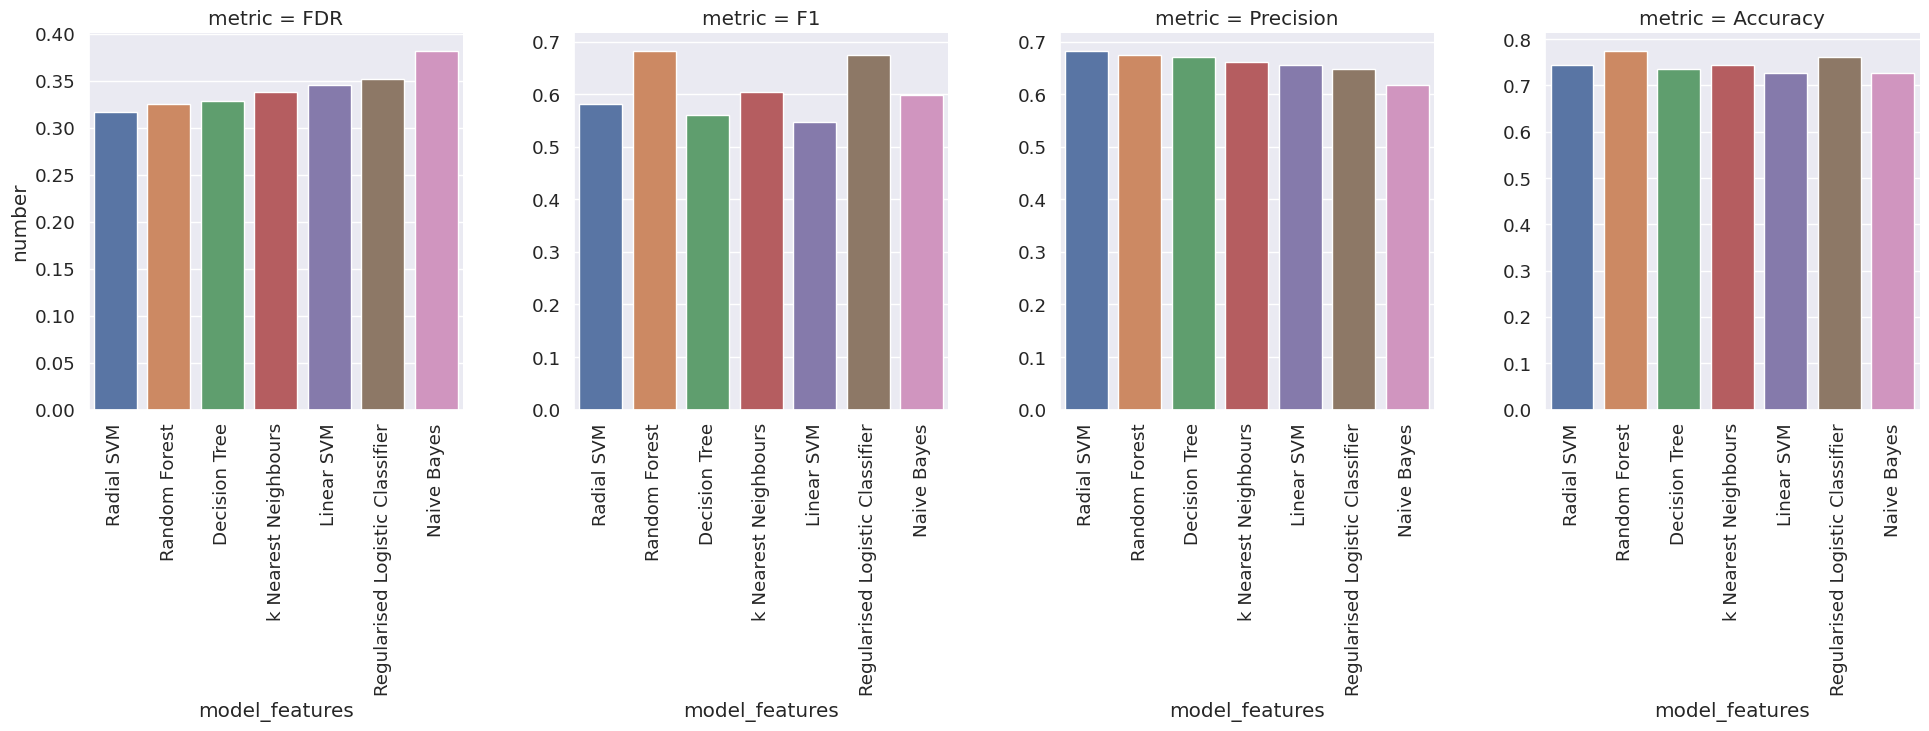

In [68]:
comp_df = comparison_stats.round(decimals=3)
fig, axes = plt.subplots(2, 1)
# prevent showing the two subplots
plt.close()

chart = sns.catplot(
    ax=axes[0],
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(comp_df[['Misclassification rate','Sensitivity','Specificity','AUC']]),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);
# ax = f.add_subplot(gs[1, 0])
chart_sub = sns.catplot(
    ax=axes[1],
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(comp_df[['Precision','Accuracy','FDR','F1']]),
    kind='bar',
    sharey=False,
#     facet_kws={'subplot_kws':{'nrows':2, 'ncols':4}}
#     nrows=2, ncols=4
)
chart_sub.set_xticklabels(rotation=90);

What do you think?

!!! keypoints "Key points"  
    - Classification attempts to predict the class to which a particular 
      observation belongs
    - Scikit-learn has tons of classifier options
    - There are many different metrics for assessing performance for a 
      classification problem
    - Which metric you choose and optimise for should be considered 
      carefully, and will be different depending on the problem
    - Exporatory data analysis is a time consuming but critical process 
      that needs to be carried out prior to any modeling
    - Support vector machines are a class of ML algorithms that construct 
      a boundary in n-dimensional space to separate different classes
    - They represent flexible methods that can handle a wide range of 
      problems, including those impossible to address using conventional 
      linear approaches
    - Different models had different best performance depending on the 
      error metric we chose to evaluate